In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-white')

## Logistic regression

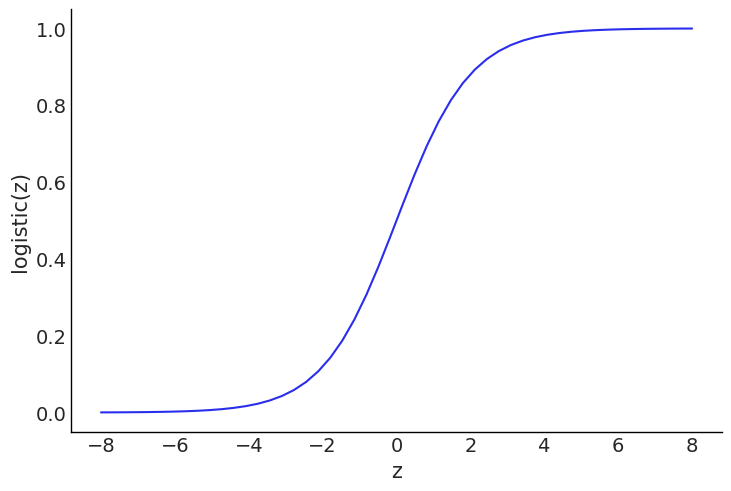

In [3]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.savefig('B11197_04_01.png');

## The iris dataset

In [4]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


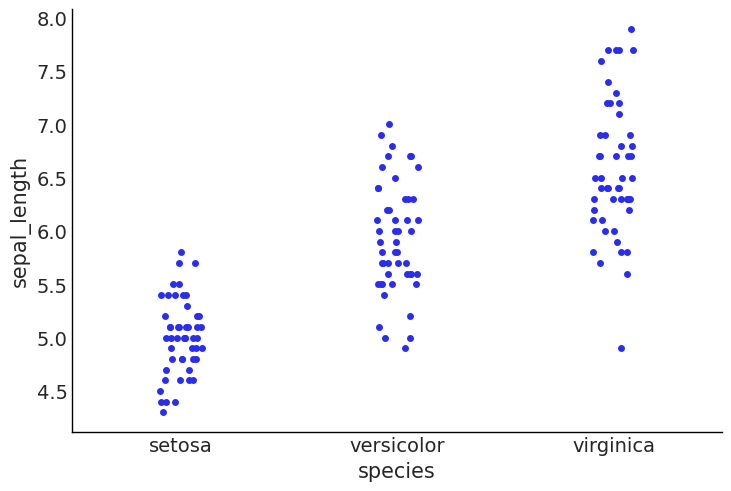

In [5]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.savefig('B11197_04_02.png');

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/seaborn/axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)
/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


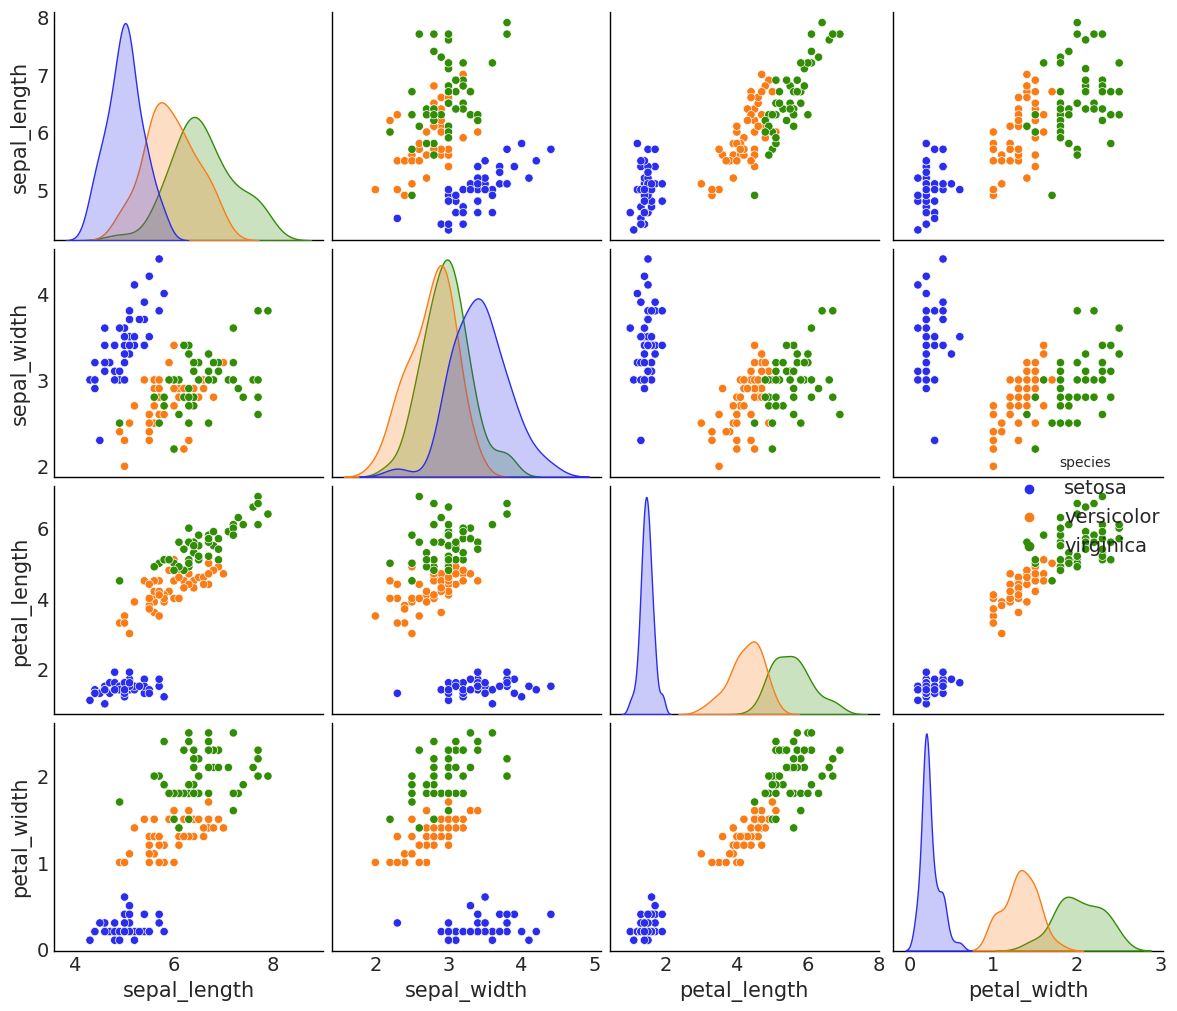

In [6]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.savefig('B11197_04_03.png', bbox_inches='tight');

### The logistic model applied to the iris dataset

In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [8]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    idata_0 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
varnames = ['α', 'β', 'bd']
az.summary(idata_0, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.307,0.338,-0.345,0.925,0.006,0.005,3192.0,2224.0,1.0
β,5.409,1.044,3.614,7.488,0.020,0.014,2955.0,2261.0,1.0
bd,-0.055,0.061,-0.166,0.060,0.001,0.001,3324.0,2722.0,1.0


/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


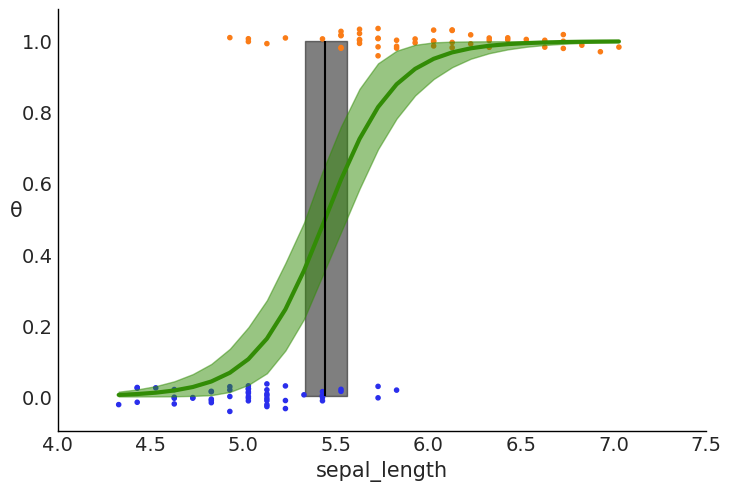

In [10]:
posterior_0 = idata_0.posterior.stack(samples=("chain", "draw"))

theta = posterior_0['θ'].mean("samples")
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(posterior_0['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, posterior_0['θ'].T, color='C2', smooth=False)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_04.png')

# Multiple logistic regression

In [11]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [12]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    idata_1 = pm.sample(2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


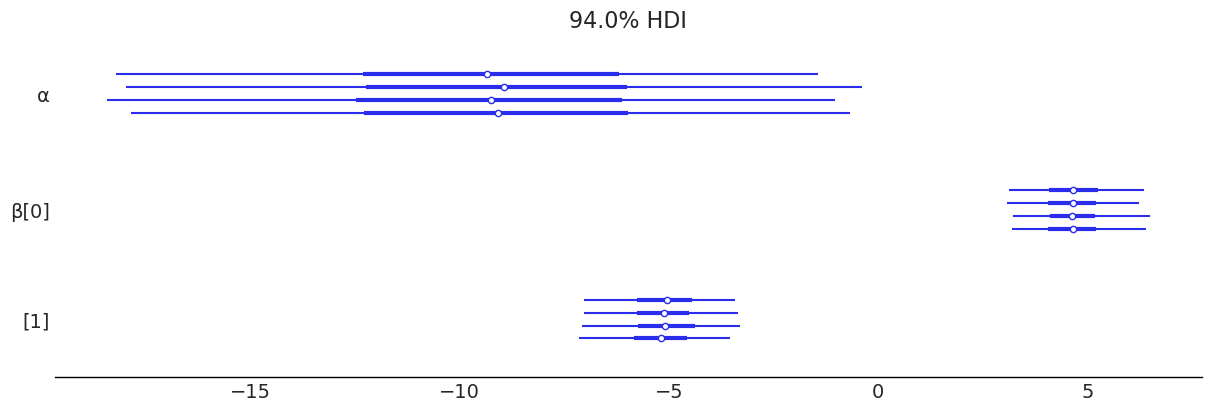

In [13]:
varnames = ['α', 'β'] 
az.plot_forest(idata_1, var_names=varnames, figsize=(12, 4));

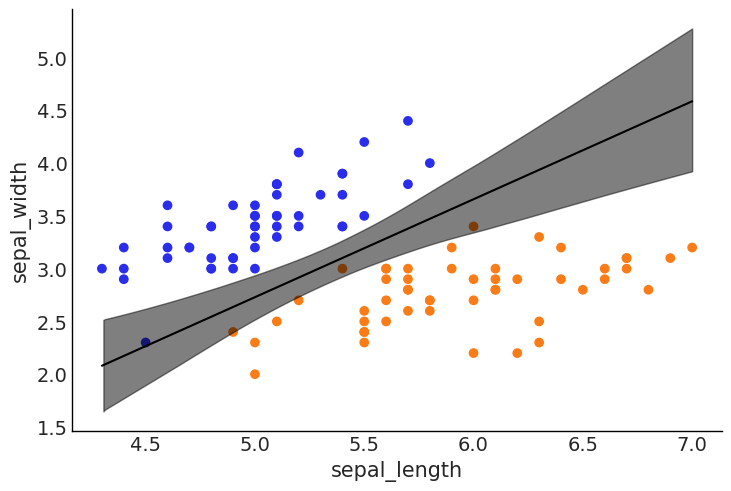

In [14]:
idx = np.argsort(x_1[:,0]) 
bd = idata_1.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hdi(x_1[:,0], idata_1.posterior['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
plt.savefig('B11197_04_05.png');

## Interpreting the coefficients of a logistic regression

/tmp/ipykernel_21185/2690055165.py:2: RuntimeWarning: divide by zero encountered in divide
  odds = probability / (1 - probability)


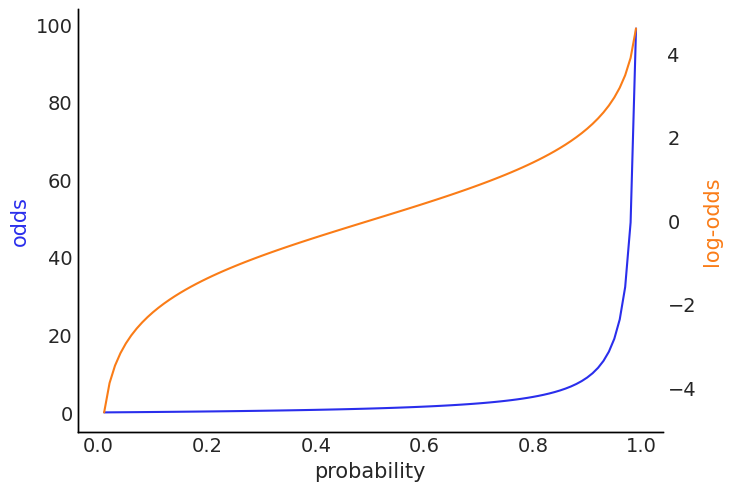

In [15]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)
plt.savefig('B11197_04_06.png');

In [16]:
df = az.summary(idata_1, var_names=varnames)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-9.170,4.617,-17.786,-0.468,0.084,0.060,3015.0,2652.0,1.0
β[0],4.661,0.851,3.158,6.390,0.016,0.012,2677.0,2848.0,1.0
β[1],-5.162,0.984,-7.043,-3.365,0.018,0.013,3020.0,3056.0,1.0


In [17]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

f"{log_odds_versicolor_f - log_odds_versicolor_i:.2f}", f"{probability_versicolor_f - probability_versicolor_i:.2f}"

('4.66', '0.70')

## Dealing with correlated variables

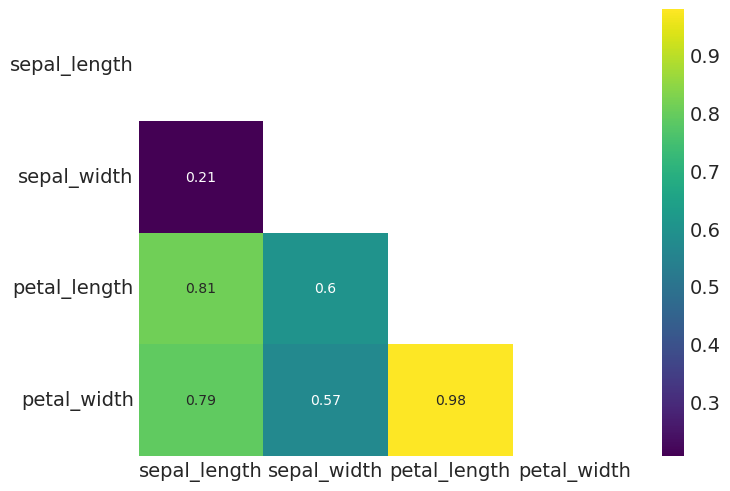

In [18]:
corr = iris[iris['species'] != 'virginica'].drop(columns="species").corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
plt.savefig('B11197_04_07.png', bbox_inches='tight');

## Dealing with unbalanced classes

In [19]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [20]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    idata_3 = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [21]:
#az.plot_trace(idata_3, varnames);

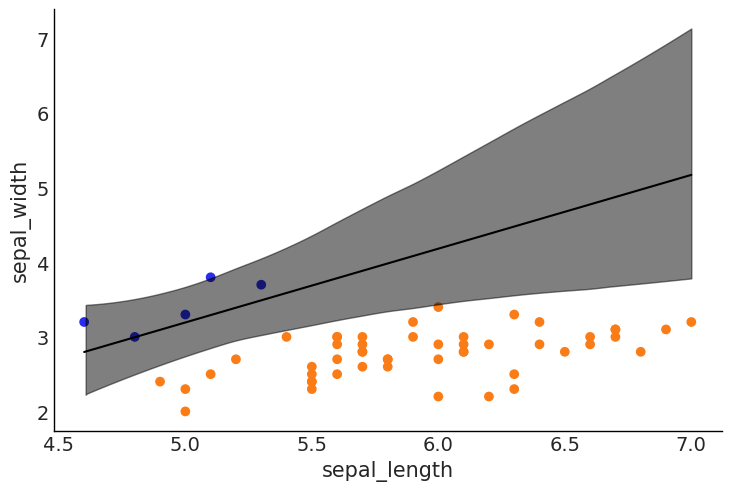

In [22]:
idx = np.argsort(x_3[:,0]) 
bd = idata_3.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hdi(x_3[:,0], idata_3.posterior['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

plt.savefig('B11197_04_08.png');

## Softmax regression

In [23]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [24]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sigma=5, shape=3)
    β = pm.Normal('β', mu=0, sigma=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = pm.math.softmax(μ, axis=1)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_s = pm.sample(2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.


In [25]:
#az.plot_forest(idata_s, var_names=['α', 'β'], figsize=(12, 4), combined=True);

In [26]:
data_pred = idata_s.posterior['μ'].mean(("chain", "draw"))

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]

f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [27]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sigma=2, shape=2)
    β = pm.Normal('β', mu=0, sigma=2, shape=(4,2))
    α_f = pt.concatenate([[0] ,α])
    β_f = pt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = pm.math.softmax(μ, axis=1)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_sf = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


## Discriminative and generative models

In [28]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu=μ[0], sigma=σ, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sigma=σ,
                           observed=x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    idata_lda = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


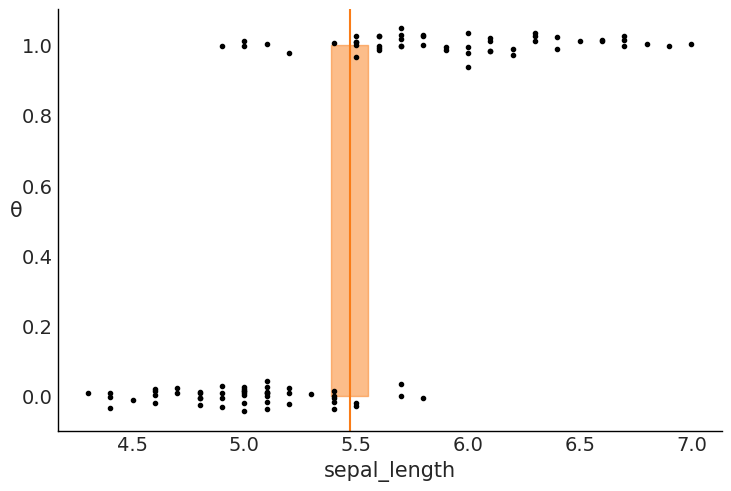

In [29]:
posterior_lda = idata_lda.posterior.stack(samples=("chain", "draw"))
plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.savefig('B11197_04_09.png')

In [30]:
az.summary(idata_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],5.007,0.062,4.896,5.124,0.001,0.001,5060.0,3007.0,1.0
μ[1],5.936,0.062,5.823,6.056,0.001,0.001,6438.0,3355.0,1.0
σ,0.447,0.033,0.386,0.509,0.000,0.000,5924.0,3015.0,1.0
bd,5.471,0.044,5.387,5.552,0.001,0.000,5865.0,3098.0,1.0


### The Poisson distribution

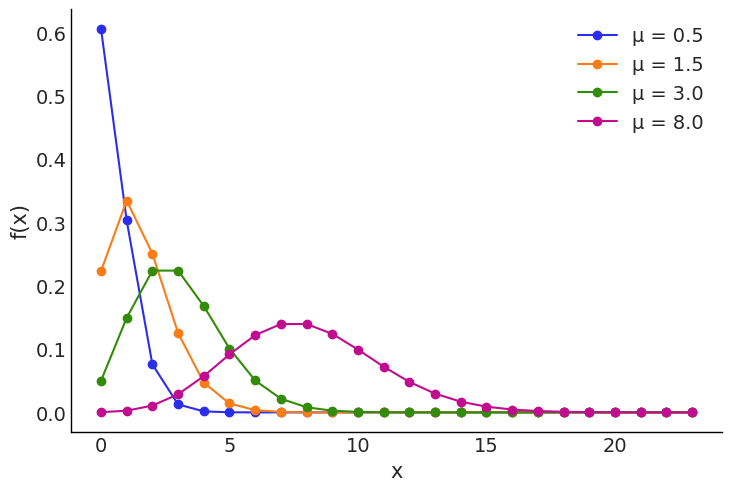

In [31]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('B11197_04_10.png');

## The Zero-Inflated Poisson model

In [32]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * 
                   np.random.poisson(θ_real) for i in range(n)])

In [33]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ,
                               observed=counts)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ψ, θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


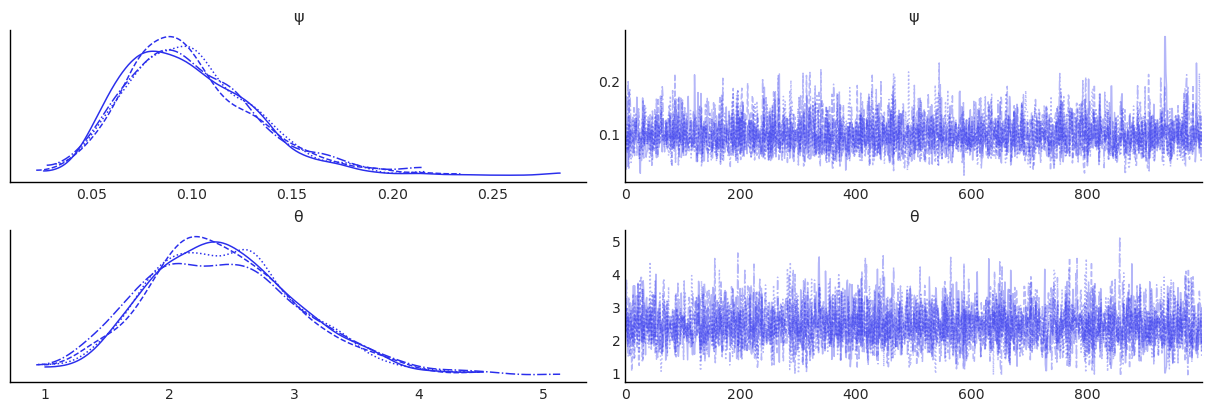

In [34]:
az.plot_trace(idata)
plt.savefig('B11197_04_11.png');

In [35]:
#az.summary(idata)

## Poisson regression and ZIP regression

In [36]:
fish_data = pd.read_csv('../data/fish.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ψ, α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


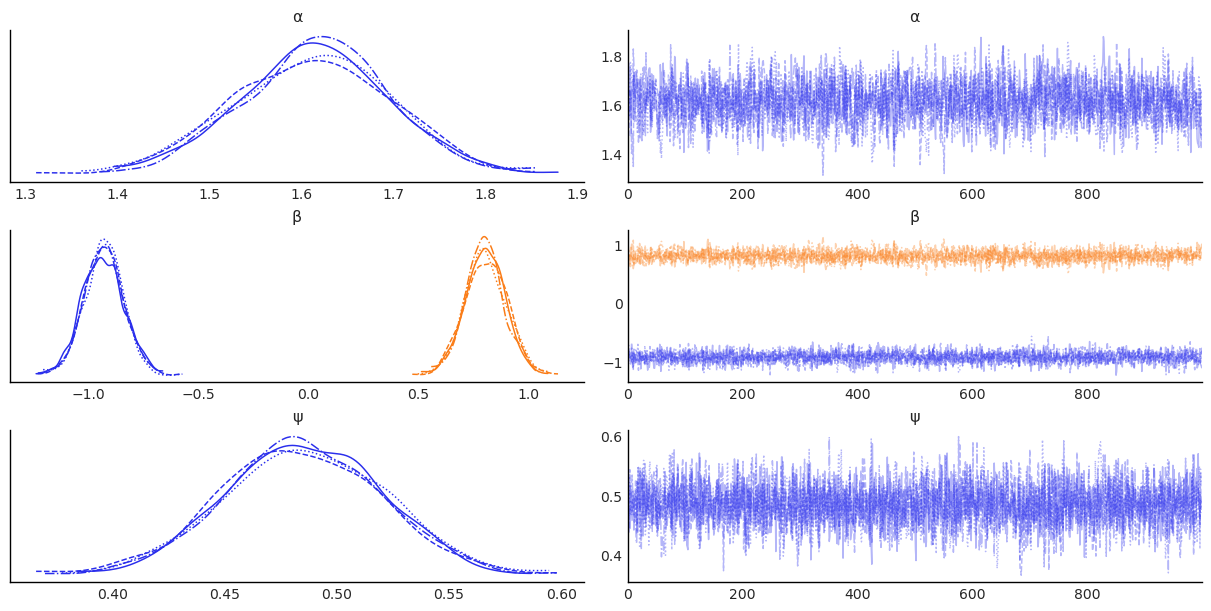

In [37]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    idata_ZIP_reg = pm.sample()
az.plot_trace(idata_ZIP_reg);

In [38]:
az.summary(idata_ZIP_reg)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.613,0.084,1.454,1.765,0.002,0.001,2159.0,2192.0,1.0
β[0],-0.929,0.090,-1.096,-0.755,0.002,0.001,2882.0,2821.0,1.0
β[1],0.805,0.091,0.646,0.991,0.002,0.001,2169.0,2344.0,1.0
ψ,0.485,0.035,0.422,0.553,0.001,0.000,3324.0,2685.0,1.0


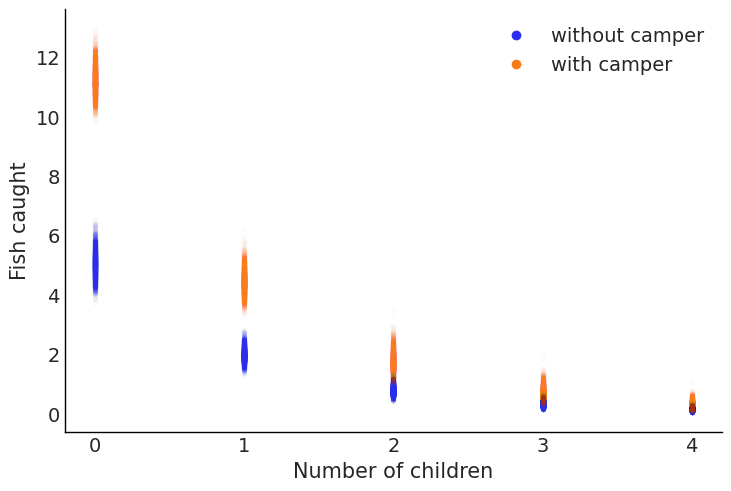

In [39]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

posterior_ZIP_reg = idata_ZIP_reg.posterior.stack(samples=("chain", "draw"))

for n in children:
    without_camper = posterior_ZIP_reg['α'] + posterior_ZIP_reg['β'].values[0] * n
    with_camper = without_camper + posterior_ZIP_reg['β'].values[1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
plt.savefig('B11197_04_12.png');

## Robust logistic regression

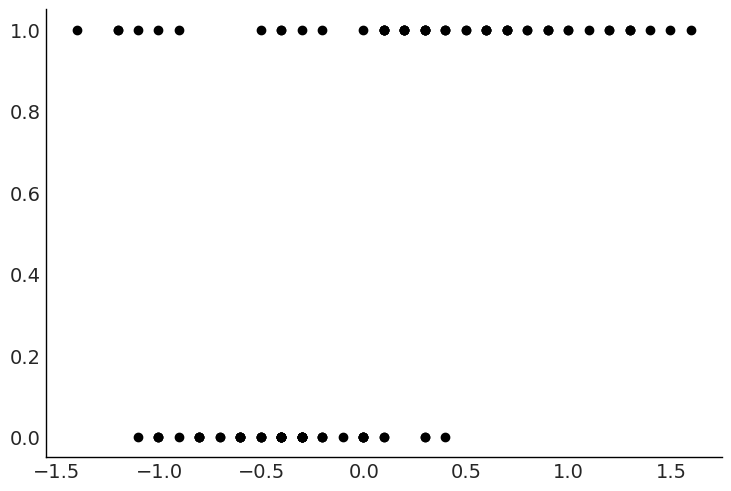

In [40]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

In [41]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1., 1.) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    idata_rlg = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, π]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


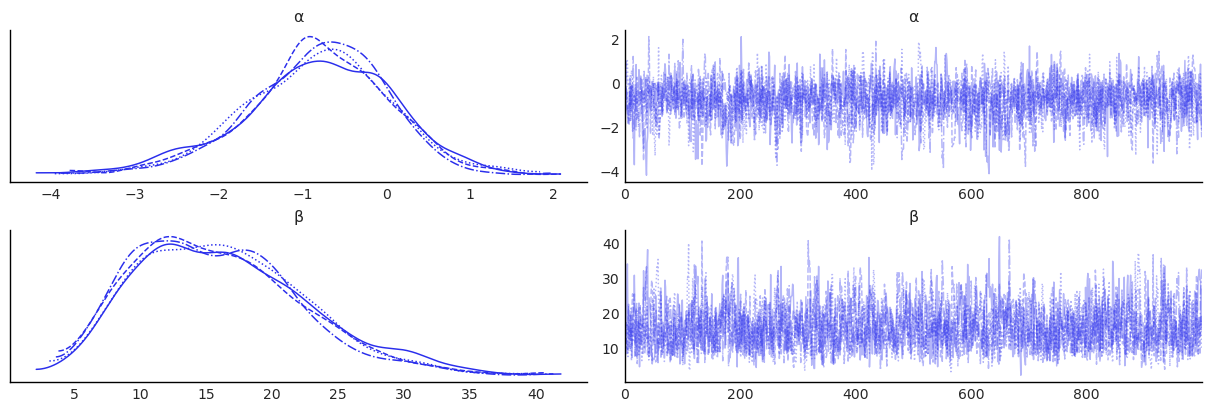

In [42]:
az.plot_trace(idata_rlg, varnames);

In [43]:
varnames = ['α', 'β', 'bd']
az.summary(idata_rlg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.817,0.873,-2.510,0.823,0.021,0.016,1798.0,2000.0,1.0
β,16.042,6.265,5.261,27.490,0.161,0.116,1579.0,1965.0,1.0
bd,0.049,0.055,-0.061,0.148,0.001,0.001,2851.0,2569.0,1.0


/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


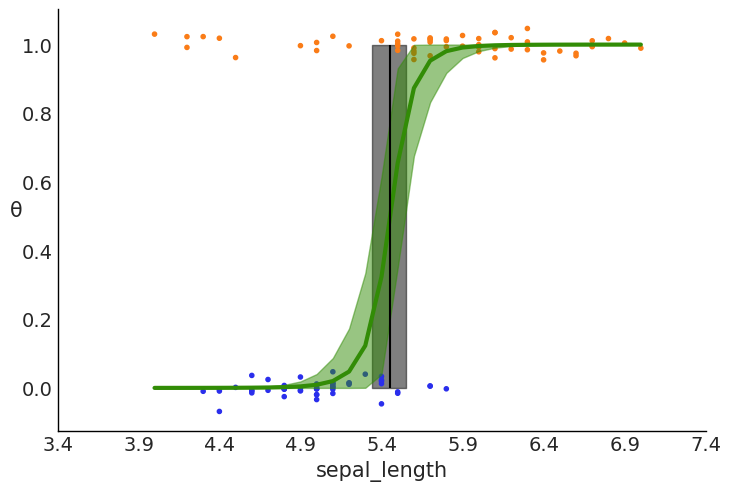

In [44]:
posterior_rlg = idata_rlg.posterior.stack(samples=("chain", "draw"))

theta = posterior_rlg['θ'].mean("samples")
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_rlg['bd'].mean(), 0, 1, color='k')
bd_hdi = az.hdi(posterior_rlg['bd'].values)
plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, posterior_rlg['θ'].T, color='C2', smooth=False)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));